In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Functions

---

In [2]:
#Removes column of class labels from dataframe and saves into new array
def features_labels_split(data, label_column):
    features = data.copy()
    columns_titles = list(data.columns)
    features = features.reindex(columns=columns_titles)
    labels = features.pop(label_column)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels


#Plots training/validation accuracy and loss. Can optionally print the numerical values.
def plot_train_val(model_history, metrics=True):
    train_acc = np.array(model_history.history["accuracy"])
    train_loss = np.array(model_history.history["loss"])

    val_loss = np.array(model_history.history["val_loss"])
    val_acc = np.array(model_history.history["val_accuracy"])

    epochs = np.arange(train_loss.shape[0])
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label = "Training")
    plt.plot(epochs, val_loss, label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5)) 
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label = "Training")
    plt.plot(epochs, val_acc, label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.show()

    train_score = [train_acc[-1], train_loss[-1]]
    val_score = [val_acc[-1], val_loss[-1]]

    if metrics == True:
        print(f"\nTraining accuracy: {round(train_score[0], 5) * 100}%")
        print(f"Training loss: {round(train_score[1], 4)}")
        print(f"\nValidation accuracy: {round(val_score[0], 5) * 100}%")
        print(f"Validation loss: {round(val_score[1], 4)}")

## Load Data

---

In [3]:
data = pd.read_csv('data/balanced_data.csv', delimiter = ",")

In [4]:
data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,Label
0,1390,53,udp,CON,0.001055,132,164,31,29,0,...,dns,500473.937500,6.218009e+05,2,2,0,0,0,0,0
1,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,-,87676.085940,5.048017e+04,4,4,0,0,0,0,0
2,1464,53,udp,CON,0.001119,146,178,31,29,0,...,dns,521894.531300,6.362824e+05,2,2,0,0,0,0,0
3,3593,53,udp,CON,0.001209,132,164,31,29,0,...,dns,436724.562500,5.425972e+05,2,2,0,0,0,0,0
4,49664,53,udp,CON,0.001169,146,178,31,29,0,...,dns,499572.250000,6.090676e+05,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161,35369,80,tcp,FIN,0.289723,864,1390,254,252,2,...,-,21482.587890,3.360451e+04,10,8,255,255,3681792013,1705323518,1
3162,24841,25,tcp,FIN,1.012112,806,1096,254,252,5,...,-,5920.293457,8.046540e+03,14,14,255,255,4198805689,2462692123,1
3163,27333,143,tcp,FIN,1.206070,1010,4962,62,252,6,...,-,6327.991211,3.126850e+04,18,20,255,255,2909098937,254268601,1
3164,25474,88,udp,CON,0.169691,2132,1512,254,60,0,...,-,75384.085940,3.564125e+04,4,2,0,0,0,0,1


In [5]:
#one hot encoding categorical columns: state, proto
proto = pd.get_dummies(data["proto"],prefix='proto')
service = pd.get_dummies(data["service"],prefix='service')
state = pd.get_dummies(data["state"],prefix='state')

data = data.merge(proto, how='outer', left_index=True, right_index=True)
data = data.merge(service, how='outer', left_index=True, right_index=True)
data = data.merge(state, how='outer', left_index=True, right_index=True)

In [6]:
data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,service_pop3,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_URH
0,1390,53,udp,CON,0.001055,132,164,31,29,0,...,0,0,0,0,0,1,0,0,0,0
1,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,0,0,0,0,0,1,0,0,0,0
2,1464,53,udp,CON,0.001119,146,178,31,29,0,...,0,0,0,0,0,1,0,0,0,0
3,3593,53,udp,CON,0.001209,132,164,31,29,0,...,0,0,0,0,0,1,0,0,0,0
4,49664,53,udp,CON,0.001169,146,178,31,29,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161,35369,80,tcp,FIN,0.289723,864,1390,254,252,2,...,0,0,0,0,0,0,1,0,0,0
3162,24841,25,tcp,FIN,1.012112,806,1096,254,252,5,...,0,0,0,0,0,0,1,0,0,0
3163,27333,143,tcp,FIN,1.206070,1010,4962,62,252,6,...,0,0,0,0,0,0,1,0,0,0
3164,25474,88,udp,CON,0.169691,2132,1512,254,60,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
data = data.drop(columns=['proto', 'state', 'service'])

In [8]:
data

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,service_pop3,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_URH
0,1390,53,0.001055,132,164,31,29,0,0,500473.937500,...,0,0,0,0,0,1,0,0,0,0
1,33661,1024,0.036133,528,304,31,29,0,0,87676.085940,...,0,0,0,0,0,1,0,0,0,0
2,1464,53,0.001119,146,178,31,29,0,0,521894.531300,...,0,0,0,0,0,1,0,0,0,0
3,3593,53,0.001209,132,164,31,29,0,0,436724.562500,...,0,0,0,0,0,1,0,0,0,0
4,49664,53,0.001169,146,178,31,29,0,0,499572.250000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161,35369,80,0.289723,864,1390,254,252,2,2,21482.587890,...,0,0,0,0,0,0,1,0,0,0
3162,24841,25,1.012112,806,1096,254,252,5,4,5920.293457,...,0,0,0,0,0,0,1,0,0,0
3163,27333,143,1.206070,1010,4962,62,252,6,8,6327.991211,...,0,0,0,0,0,0,1,0,0,0
3164,25474,88,0.169691,2132,1512,254,60,0,0,75384.085940,...,0,0,0,0,0,1,0,0,0,0


In [9]:
#Separate data from the labels in the pandas dataframe into their own numpy arrays
x, y = features_labels_split(data, 'Label')

print(x.shape)
print(y.shape)

(3166, 165)
(3166,)


In [10]:
#Separate data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

x_train shape:  (2216, 165)
y_train shape:  (2216,)
x_test shape:  (475, 165)
y_test shape:  (475,)
x_val shape:  (475, 165)
y_val shape:  (475,)


In [11]:
#Label one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print('y_train one-hot shape: ', y_train.shape)
print('y_val one-hot shape: ', y_val.shape)
print('y_test one-hot shape: ', y_test.shape)


y_train one-hot shape:  (2216, 2)
y_val one-hot shape:  (475, 2)
y_test one-hot shape:  (475, 2)


In [12]:
#Scaling
scaler = MinMaxScaler() 

x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val) 
x_test = scaler.transform(x_test)

In [13]:
y_test.shape

(475, 2)

## ANN Model

<img src="img/ann.png">


*'DEEP-INTRUSION DETECTION SYSTEM WITH ENHANCED UNSW-NB15 DATASET BASED ON DEEP LEARNING TECHNIQUES', A.M. ALEESA, MOHAMMED YOUNIS, AHMED A. MOHAMMED, NAN M. SAHAR*


---

In [14]:
#Define
model = Sequential()

model.add(Dense(input_dim=x_train.shape[1], units=850, activation='relu')) #input & hidden layer 1
model.add(Dense(units=2, activation='softmax')) #output/prediction layer

model.summary() #display model architecture information

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 850)               141100    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1702      
Total params: 142,802
Trainable params: 142,802
Non-trainable params: 0
_________________________________________________________________


In [31]:
#Compile
model.compile(loss="binary_crossentropy",  #they did not specify loss function, assume binary cross entropy
        optimizer=Adam(learning_rate=0.001), #they did not specify learning rate, placeholder value for now
        metrics=["accuracy"])

In [32]:
clear_session()

#Fit
start = time()
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=100,
    verbose=1 #do not display output as model is training
)


print(f'Complete. \nModel trained in {round(time()-start, 2)} sec')

Epoch 1/100
23/23 [==============================] - 2s 20ms/step - loss: 1.0072e-08 - accuracy: 1.0000 - val_loss: 9.4247e-09 - val_accuracy: 1.0000
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 1.0138e-08 - accuracy: 1.0000 - val_loss: 9.4087e-09 - val_accuracy: 1.0000
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 9.0905e-09 - accuracy: 1.0000 - val_loss: 9.3806e-09 - val_accuracy: 1.0000
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 9.6745e-09 - accuracy: 1.0000 - val_loss: 9.3642e-09 - val_accuracy: 1.0000
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0820e-08 - accuracy: 1.0000 - val_loss: 9.3367e-09 - val_accuracy: 1.0000
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0677e-08 - accuracy: 1.0000 - val_loss: 9.3061e-09 - val_accuracy: 1.0000
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 1.2372e-08 - accuracy: 1.0000 - 

Training and Validation Loss/Accuracy Curves

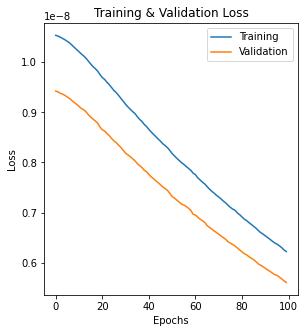

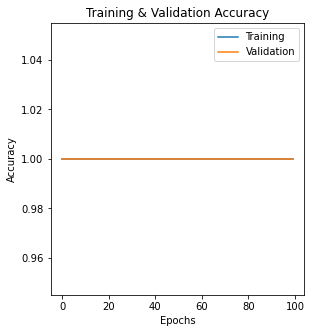


Training accuracy: 100.0%
Training loss: 0.0

Validation accuracy: 100.0%
Validation loss: 0.0


In [33]:
plot_train_val(history)

## Evaluation Metrics

(fill in later...)

---

In [21]:
y_pred = np.argmax(model.predict(x_test), axis=-1) 
y_true = np.argmax(y_test, axis=-1) 

acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision  = precision_score(y_true, y_pred, average='weighted')
f1  = f1_score(y_true, y_pred, average='weighted')

print('Accuracy: ', acc)
print('Precision: ', recall)
print('Recall: ', precision)
print('F1-score: ', f1)
# print('AUC: ', auc)

# y_test_one_hot = to_categorical(y_test) #roc_auc_score function needs data in one-hot encoding format for multiclass classification
# auc  = roc_auc_score(y_test_one_hot, trained_model.predict_proba(x_test), average='weighted', multi_class='ovr')

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-score:  1.0


### Confusion Matrix

---